In [12]:
import numpy as np
np.random.seed(42)
import random
random.seed(42)

import matplotlib.pyplot as plt
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import NMF
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import KFold
from sklearn.metrics import log_loss
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
import nltk
from nltk import pos_tag
from nltk.corpus import stopwords
from string import punctuation

def Q1():
    twenty_all_train = fetch_20newsgroups()
    plt.hist(twenty_all_train.target, bins=20)
    plt.title("Histogram of documents per topic")
    plt.xlabel("Topic")
    plt.ylabel("Number of documents")
    plt.show()

def penn2morphy(penntag):
    """ Converts Penn Treebank tags to WordNet. """
    morphy_tag = {'NN':'n', 'JJ':'a',
                  'VB':'v', 'RB':'r'}
    try:
        return morphy_tag[penntag[:2]]
    except:
        return 'n'

def lemmatize_sent(list_word):
    # Text input is string, returns array of lowercased strings(words).
    wnl = nltk.wordnet.WordNetLemmatizer()
    return [wnl.lemmatize(word.lower(), pos=penn2morphy(tag)) 
            for word, tag in pos_tag(list_word)]

def stem_rmv_punc(doc):
    analyzer = CountVectorizer().build_analyzer()
    stop_words_skt = text.ENGLISH_STOP_WORDS
    stop_words_en = stopwords.words('english')
    combined_stopwords = set.union(set(stop_words_en),set(punctuation),set(stop_words_skt))
    return (word for word in lemmatize_sent(analyzer(doc)) if word not in combined_stopwords and not word.isdigit())

def GetLSA(data, k=50):
    svd = TruncatedSVD(n_components=k, random_state=0)
    data_reduced = svd.fit_transform(data)
    error = np.sum(np.array(data - svd.inverse_transform(data_reduced))**2)
    return data_reduced, error

def GetNMF(data, k=50):
    model = NMF(n_components=k, init='random', random_state=0)
    data_reduced = model.fit_transform(data)
    error = np.sum(np.array(data - data_reduced.dot(model.components_))**2)
    return data_reduced, error

def GetTFData(multiclass=False):
    comp_categories = ['comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware']
    rec_categories = ['rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey']
    all_categories = comp_categories + rec_categories
    if multiclass:
        all_categories = ['comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'misc.forsale', 'soc.religion.christian']
        
    twenty_train = fetch_20newsgroups(subset='train', categories=all_categories, shuffle=True, random_state=None)
    twenty_test = fetch_20newsgroups(subset='test', categories=all_categories, shuffle=True, random_state=None)

    count_vect = CountVectorizer(min_df=3, analyzer=stem_rmv_punc, stop_words='english')
    tfidf_transformer = TfidfTransformer()

    X_train_counts = count_vect.fit_transform(twenty_train.data)
    X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
    print("Train tf-idf shape:", X_train_tfidf.shape)

    X_test_counts = count_vect.fit_transform(twenty_test.data)
    X_test_tfidf = tfidf_transformer.fit_transform(X_test_counts)
    print("Test tf-idf shape:", X_test_tfidf.shape)
    print()

    if multiclass:
        y_train = twenty_train.target
        y_test = twenty_test.target
    else:
        y_train = np.array(twenty_train.target > 3)
        y_test = np.array(twenty_test.target > 3)

    return X_train_tfidf, X_test_tfidf, y_train, y_test

def GetData(get_nmf_error=False, multiclass=False):
    X_train, X_test, y_train, y_test = GetTFData(multiclass=multiclass)

    X_train_LSA, error_train_LSA = GetLSA(X_train)
    X_test_LSA, error_test_LSA = GetLSA(X_test)
    print("X_train LSA error:", error_train_LSA)
    print("X_test LSA error:", error_test_LSA)

    if get_nmf_error:
        _, error_train_NMF = GetNMF(X_train)
        _, error_test_NMF = GetNMF(X_test)
        print("X_train NMF error:", error_train_NMF)
        print("X_test NMF error:", error_test_NMF)
        
    print()
    return np.array(X_train_LSA), np.array(X_test_LSA), np.array(y_train), np.array(y_test)

def TrainTestModel(model, X_train, y_train, X_test, y_test, name, show_log_loss=False, multiclass=False):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    if multiclass:
        class_names = ['comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'misc.forsale', 'soc.religion.christian']
    else:
        class_names = ['comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware'] + ['rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey']
    
    plot_confusion_matrix(model, X_test, y_test, display_labels=class_names, cmap=plt.cm.Blues, normalize='true', xticks_rotation='vertical', values_format='.1g')

    average = 'weighted' if multiclass else 'binary'
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average=average)
    recall = recall_score(y_test, y_pred, average=average)
    F1 = f1_score(y_test, y_pred, average=average)

    print("Results for {} -".format(name))
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1-Score:", F1)
    if show_log_loss:
        print("Log Loss:", log_loss(y_test, y_pred))
    print()

    if not multiclass:
        plot_roc_curve(model, X_test, y_test)
        plt.title(name + " ROC Curve")
        plt.show()

def CrossValSVM(X_train, y_train, X_test, y_test):
    kf = KFold(n_splits=5)
    max_acc = 0.0
    max_k = -3
    for k in range(-3, 4):
        svm = LinearSVC(C=10**k, max_iter=5000)
        acc = 0.0
        for train_index, test_index in kf.split(X_train):
            svm.fit(X_train[train_index], y_train[train_index])
            acc += svm.score(X_train[test_index], y_train[test_index])
        acc /= 5
        if acc > max_acc:
            max_acc = acc
            max_k = k

    print("Max cross val accuracy:", max_acc)
    print("Max K:", max_k)
    print()
    svm = LinearSVC(C=10**max_k, max_iter=5000)
    TrainTestModel(svm, X_train, y_train, X_test, y_test, "Best SVM")

def CrossValLogisticRegression(X_train, y_train, X_test, y_test):
    kf = KFold(n_splits=5)
    penalties = ['l2', 'l1']
    for penalty in penalties:
        max_acc = 0.0
        max_k = -3
        for k in range(-3, 4):
            model = LogisticRegression(penalty=penalty, C=10**k, solver='liblinear')
            acc = 0.0
            for train_index, test_index in kf.split(X_train):
                model.fit(X_train[train_index], y_train[train_index])
                acc += model.score(X_train[test_index], y_train[test_index])
            acc /= 5
            if acc > max_acc:
                max_acc = acc
                max_k = k
        
        print("Max cross val accuracy for {} regulaizer:".format(penalty), max_acc)
        print("Max k:", max_k)
        print("Coefficients:", model.coef_)
        print()
        model = LogisticRegression(penalty=penalty, C=10**max_k, solver='liblinear')
        TrainTestModel(model, X_train, y_train, X_test, y_test, penalty + " Regularized Logistic Regression", show_log_loss=True)

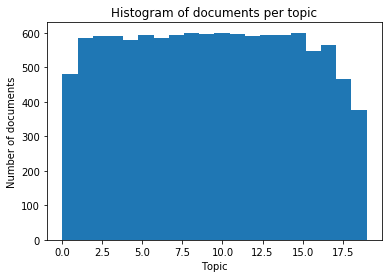

In [2]:
Q1()

In [3]:
X_train, X_test, y_train, y_test = GetData(get_nmf_error=True)
hard_svm = LinearSVC(C=1000.0, max_iter=5000)
TrainTestModel(hard_svm, X_train, y_train, X_test, y_test, "Hard SVM")

Train tf-idf shape: (4732, 16292)
Test tf-idf shape: (3150, 11218)

X_train LSA error: 4108.290852549683
X_test LSA error: 2670.829213066998
X_train NMF error: 4146.200767808938
X_test NMF error: 2698.933110573214



C:\Users\shb20\Anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


NameError: name 'normalize' is not defined

Results for Soft SVM -
Accuracy: 0.6171428571428571
Precision: 0.56941431670282
Recall: 0.9905660377358491
F1-Score: 0.7231404958677685



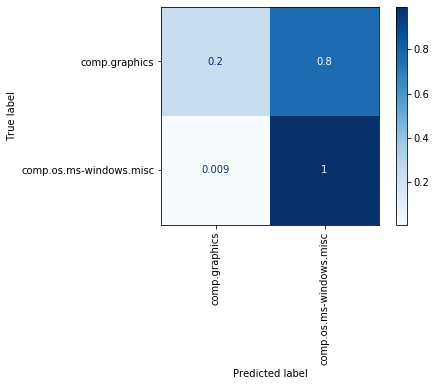

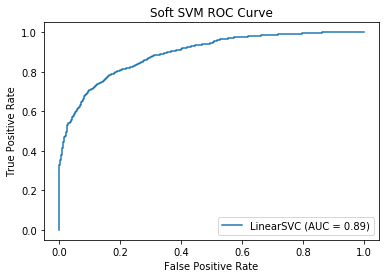

In [11]:
soft_svm = LinearSVC(C=0.0001)
TrainTestModel(soft_svm, X_train, y_train, X_test, y_test, "Soft SVM")

C:\Users\shb20\Anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\shb20\Anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\shb20\Anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\shb20\Anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Max cross val accuracy: 0.9765408065081452
Max K: 0

Results for Best SVM -
Confusion Matrix:
 [[1400  160]
 [ 614  976]]
Accuracy: 0.7542857142857143
Precision: 0.8591549295774648
Recall: 0.6138364779874214
F1-Score: 0.7160674981658106



C:\Users\shb20\Anaconda3\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


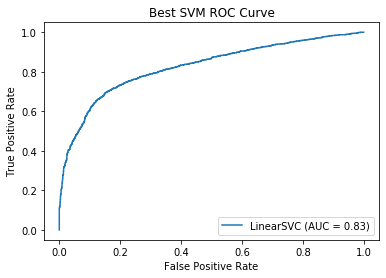

In [25]:
CrossValSVM(X_train, y_train, X_test, y_test)

C:\Users\shb20\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Results for No Regularization Logistic Regression -
Confusion Matrix:
 [[1375  185]
 [ 697  893]]
Accuracy: 0.72
Precision: 0.8283858998144712
Recall: 0.5616352201257861
F1-Score: 0.6694152923538231



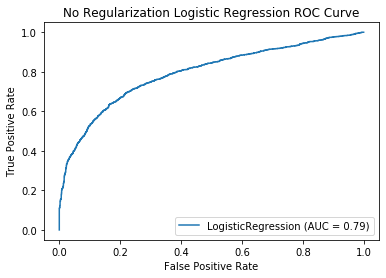

In [26]:
no_reg_model = LogisticRegression(penalty='none')
TrainTestModel(no_reg_model, X_train, y_train, X_test, y_test, "No Regularization Logistic Regression")

Max cross val accuracy for l2 regulaizer: 0.976330283012339
Max k: 2
Coefficients: [[-1.18736845e-01  1.14382555e+02 -1.72631955e+01  8.27375533e+01
   1.22924117e+01 -1.50854564e+01 -6.21640440e+00 -1.32136455e+00
   2.13271135e+01  1.45500796e+01  3.24141003e+01 -2.64875530e+00
  -7.66717654e+00  7.26053036e+00 -1.58911799e+01  2.39373452e+00
  -5.25142922e+00  1.33334594e+01  1.15886764e+01  8.16532181e-01
   5.43446220e+00 -8.66079241e+00 -3.24962988e+00  6.25463813e+00
   8.10618385e+00  1.72963803e-01 -5.31053348e+00 -2.10480368e+01
   2.92639653e+00 -1.60322784e+01  1.02999389e+01  6.56544389e+00
   3.53044189e-03 -4.00652954e+00 -5.38694773e+00 -3.14807104e+00
   7.89563656e+00 -3.29464510e+00 -6.21646955e+00 -5.19671627e+00
  -9.74041390e+00 -8.37146908e-01  5.62815102e+00 -1.26122909e+01
  -1.71177358e+00  2.08079478e+01  1.19646691e+01 -9.67849666e-01
  -8.43350081e+00 -5.95472300e+00]]

Results for l2 Regularized Logistic Regression -
Confusion Matrix:
 [[1390  170]
 [ 651 

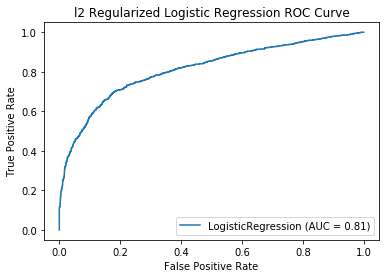

Max cross val accuracy for l1 regulaizer: 0.9765412530054853
Max k: 1
Coefficients: [[-6.62026748e-01  1.26690218e+02 -1.89972291e+01  9.26131078e+01
   1.40050952e+01 -1.87608964e+01 -7.04026336e+00 -1.66667579e+00
   2.38030379e+01  1.54459951e+01  3.62068088e+01 -2.36540187e+00
  -7.65659712e+00  8.03855333e+00 -1.83391881e+01  3.25193018e+00
  -6.15465640e+00  1.48112648e+01  1.24726834e+01  1.01667389e-02
   7.00102706e+00 -1.17405928e+01 -3.09740336e+00  8.21351269e+00
   8.01502167e+00  1.27831315e+00 -7.20279551e+00 -2.52911617e+01
   3.70226606e+00 -1.71202897e+01  1.12173016e+01  6.93132767e+00
  -4.58593499e-01 -5.02366779e+00 -6.36284596e+00 -3.54622817e+00
   8.99978807e+00 -3.45503537e+00 -6.56166622e+00 -6.89362422e+00
  -1.14286696e+01 -1.63539205e+00  6.56997309e+00 -1.48167376e+01
  -2.43934038e+00  2.41991474e+01  1.37324513e+01 -8.86967040e-01
  -9.79105088e+00 -6.75267718e+00]]

Results for l1 Regularized Logistic Regression -
Confusion Matrix:
 [[1399  161]
 [ 660

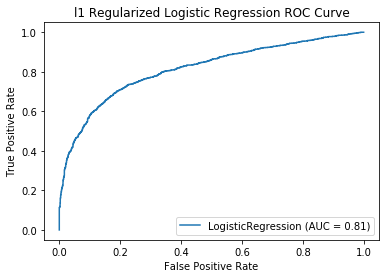

In [27]:
CrossValLogisticRegression(X_train, y_train, X_test, y_test)

Results for GaussianNB -
Confusion Matrix:
 [[1282  278]
 [ 629  961]]
Accuracy: 0.7120634920634921
Precision: 0.7756255044390638
Recall: 0.6044025157232704
F1-Score: 0.6793920113114174



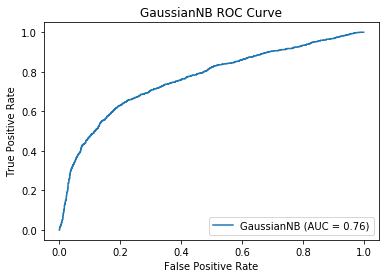

In [28]:
NB = GaussianNB()
TrainTestModel(NB, X_train, y_train, X_test, y_test, "GaussianNB")

In [9]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

# used to cache results
from tempfile import mkdtemp
from shutil import rmtree
from sklearn.externals.joblib import Memory
# print(__doc__)
cachedir = mkdtemp()
memory = Memory(cachedir=cachedir, verbose=10)

pipeline = Pipeline([
    ('vect', CountVectorizer(min_df=1, stop_words='english')),
    ('tfidf', TfidfTransformer()),
    ('reduce_dim', TruncatedSVD(random_state=0)),
    ('clf', GaussianNB()),
],
memory=memory
)

N_FEATURES_OPTIONS = [50]

param_grid = [
    {
        'vect' : [CountVectorizer(stop_words='english')],
        'vect__min_df': [3, 5],
        'vect__analyzer' : ['word', stem_rmv_punc],
        'reduce_dim': [TruncatedSVD(), NMF()],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'clf': [LinearSVC()],
        'clf__C': [1]
    },
    {
        'vect' : [CountVectorizer(stop_words='english')],
        'vect__min_df': [3, 5],
        'vect__analyzer' : ['word', stem_rmv_punc],
        'reduce_dim': [TruncatedSVD(), NMF()],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'clf': [LogisticRegression(solver='liblinear')],
        'clf__penalty' : ['l2'],
        'clf__C' : [100]
    },
    {
        'vect' : [CountVectorizer(stop_words='english')],
        'vect__min_df': [3, 5],
        'vect__analyzer' : ['word', stem_rmv_punc],
        'reduce_dim': [TruncatedSVD(), NMF()],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'clf': [LogisticRegression(solver='liblinear')],
        'clf__penalty' : ['l1'],
        'clf__C' : [10]
    },
    {
        'vect' : [CountVectorizer(stop_words='english')],
        'vect__min_df': [3, 5],
        'vect__analyzer' : ['word', stem_rmv_punc],
        'reduce_dim': [TruncatedSVD(), NMF()],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'clf': [GaussianNB()],
    },
]

C:\Users\shb20\Anaconda3\lib\site-packages\sklearn\externals\joblib\__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)
C:\Users\shb20\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: The 'cachedir' parameter has been deprecated in version 0.12 and will be removed in version 0.14.
You provided "cachedir='C:\\Users\\shb20\\AppData\\Local\\Temp\\tmpo3xqm8p3'", use "location='C:\\Users\\shb20\\AppData\\Local\\Temp\\tmpo3xqm8p3'" instead.
  # Remove the CWD from sys.path while we load stuff.


In [12]:
comp_categories = ['comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware']
rec_categories = ['rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey']
all_categories = comp_categories + rec_categories

twenty_train = fetch_20newsgroups(subset='train', categories=all_categories, shuffle=True, random_state=None)
twenty_test = fetch_20newsgroups(subset='test', categories=all_categories, shuffle=True, random_state=None)

grid = GridSearchCV(pipeline, cv=5, n_jobs=1, param_grid=param_grid, scoring='accuracy')
grid.fit(twenty_train.data, np.array(twenty_train.target > 3), verbose=False)
rmtree(cachedir)

________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=3,
                ngram_range=(1, 1), preprocessor=None, stop_words='english',
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None), 
[ 'From: jslam@cbnewsl.cb.att.com (joseph.lam)\n'
  'Subject: Re: Request for Islanders e-mail list\n'
  'Article-I.D.: cbnewsl.1993Apr5.183014.16567\n'
  'Distribution: na\n'
  'Organization: AT&T\n'
  'Lines: 26\n'
  '\n'
  'In article <1993Apr3.014237.20959@sifon.cc.mcgill.ca> '
  'bui@ee470.ee.mcgill.ca (BUI/DON/MR) writes:\n'
  '>In article <16b5xvf@rpi.edu> wangr@rpi.edu writes:\n'
  '>>>If anyone out there is ke

C:\Users\shb20\Anaconda3\lib\site-packages\sklearn\pipeline.py:315: UserWarning: Persisting input arguments took 2.48s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])


________________________________________________fit_transform_one - 2.4s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True), <3785x16943 sparse matrix of type '<class 'numpy.int64'>'
	with 321224 stored elements in Compressed Sparse Row format>, 
array([ True, ..., False]), None, message_clsname='Pipeline', message=None)
________________________________________________fit_transform_one - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5,
             random_state=None, tol=0.0), 
<3785x16943 sparse matrix of type '<class 'numpy.float64'>'
	with 321224 stored elements in Compressed Sparse Row format>, 
array([ True, ...

C:\Users\shb20\Anaconda3\lib\site-packages\sklearn\pipeline.py:315: UserWarning: Persisting input arguments took 2.58s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])


________________________________________________fit_transform_one - 2.5s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True), <3785x17418 sparse matrix of type '<class 'numpy.int64'>'
	with 326442 stored elements in Compressed Sparse Row format>, 
array([ True, ..., False]), None, message_clsname='Pipeline', message=None)
________________________________________________fit_transform_one - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5,
             random_state=None, tol=0.0), 
<3785x17418 sparse matrix of type '<class 'numpy.float64'>'
	with 326442 stored elements in Compressed Sparse Row format>, 
array([ True, ...

C:\Users\shb20\Anaconda3\lib\site-packages\sklearn\pipeline.py:315: UserWarning: Persisting input arguments took 2.60s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])


________________________________________________fit_transform_one - 2.7s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True), <3786x17693 sparse matrix of type '<class 'numpy.int64'>'
	with 326062 stored elements in Compressed Sparse Row format>, 
array([ True, ..., False]), None, message_clsname='Pipeline', message=None)
________________________________________________fit_transform_one - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5,
             random_state=None, tol=0.0), 
<3786x17693 sparse matrix of type '<class 'numpy.float64'>'
	with 326062 stored elements in Compressed Sparse Row format>, 
array([ True, ...

C:\Users\shb20\Anaconda3\lib\site-packages\sklearn\pipeline.py:315: UserWarning: Persisting input arguments took 2.23s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])


________________________________________________fit_transform_one - 2.4s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True), <3786x17251 sparse matrix of type '<class 'numpy.int64'>'
	with 331097 stored elements in Compressed Sparse Row format>, 
array([ True, ..., False]), None, message_clsname='Pipeline', message=None)
________________________________________________fit_transform_one - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5,
             random_state=None, tol=0.0), 
<3786x17251 sparse matrix of type '<class 'numpy.float64'>'
	with 331097 stored elements in Compressed Sparse Row format>, 
array([ True, ...

C:\Users\shb20\Anaconda3\lib\site-packages\sklearn\pipeline.py:315: UserWarning: Persisting input arguments took 2.39s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])


________________________________________________fit_transform_one - 2.4s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True), <3786x17725 sparse matrix of type '<class 'numpy.int64'>'
	with 332897 stored elements in Compressed Sparse Row format>, 
array([ True, ..., False]), None, message_clsname='Pipeline', message=None)
________________________________________________fit_transform_one - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5,
             random_state=None, tol=0.0), 
<3786x17725 sparse matrix of type '<class 'numpy.float64'>'
	with 332897 stored elements in Compressed Sparse Row format>, 
array([ True, ...

C:\Users\shb20\Anaconda3\lib\site-packages\sklearn\pipeline.py:315: UserWarning: Persisting input arguments took 1.83s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])


________________________________________________fit_transform_one - 2.8s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True), <3785x10761 sparse matrix of type '<class 'numpy.int64'>'
	with 300371 stored elements in Compressed Sparse Row format>, 
array([ True, ..., False]), None, message_clsname='Pipeline', message=None)
________________________________________________fit_transform_one - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5,
             random_state=None, tol=0.0), 
<3785x10761 sparse matrix of type '<class 'numpy.float64'>'
	with 300371 stored elements in Compressed Sparse Row format>, 
array([ True, ...

C:\Users\shb20\Anaconda3\lib\site-packages\sklearn\pipeline.py:315: UserWarning: Persisting input arguments took 1.74s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])


________________________________________________fit_transform_one - 2.3s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True), <3785x10933 sparse matrix of type '<class 'numpy.int64'>'
	with 304546 stored elements in Compressed Sparse Row format>, 
array([ True, ..., False]), None, message_clsname='Pipeline', message=None)
________________________________________________fit_transform_one - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5,
             random_state=None, tol=0.0), 
<3785x10933 sparse matrix of type '<class 'numpy.float64'>'
	with 304546 stored elements in Compressed Sparse Row format>, 
array([ True, ...

C:\Users\shb20\Anaconda3\lib\site-packages\sklearn\pipeline.py:315: UserWarning: Persisting input arguments took 1.54s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])


________________________________________________fit_transform_one - 2.5s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True), <3786x11050 sparse matrix of type '<class 'numpy.int64'>'
	with 303632 stored elements in Compressed Sparse Row format>, 
array([ True, ..., False]), None, message_clsname='Pipeline', message=None)
________________________________________________fit_transform_one - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5,
             random_state=None, tol=0.0), 
<3786x11050 sparse matrix of type '<class 'numpy.float64'>'
	with 303632 stored elements in Compressed Sparse Row format>, 
array([ True, ...

C:\Users\shb20\Anaconda3\lib\site-packages\sklearn\pipeline.py:315: UserWarning: Persisting input arguments took 1.61s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])


________________________________________________fit_transform_one - 2.3s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True), <3786x11124 sparse matrix of type '<class 'numpy.int64'>'
	with 310397 stored elements in Compressed Sparse Row format>, 
array([ True, ..., False]), None, message_clsname='Pipeline', message=None)
________________________________________________fit_transform_one - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5,
             random_state=None, tol=0.0), 
<3786x11124 sparse matrix of type '<class 'numpy.float64'>'
	with 310397 stored elements in Compressed Sparse Row format>, 
array([ True, ...

C:\Users\shb20\Anaconda3\lib\site-packages\sklearn\pipeline.py:315: UserWarning: Persisting input arguments took 2.23s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])


________________________________________________fit_transform_one - 2.9s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True), <3786x11261 sparse matrix of type '<class 'numpy.int64'>'
	with 311111 stored elements in Compressed Sparse Row format>, 
array([ True, ..., False]), None, message_clsname='Pipeline', message=None)
________________________________________________fit_transform_one - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5,
             random_state=None, tol=0.0), 
<3786x11261 sparse matrix of type '<class 'numpy.float64'>'
	with 311111 stored elements in Compressed Sparse Row format>, 
array([ True, ...

C:\Users\shb20\Anaconda3\lib\site-packages\sklearn\pipeline.py:315: UserWarning: Persisting input arguments took 1.74s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])


_______________________________________________fit_transform_one - 67.5s, 1.1min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True), <3785x13485 sparse matrix of type '<class 'numpy.int64'>'
	with 281113 stored elements in Compressed Sparse Row format>, 
array([ True, ..., False]), None, message_clsname='Pipeline', message=None)
________________________________________________fit_transform_one - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5,
             random_state=None, tol=0.0), 
<3785x13485 sparse matrix of type '<class 'numpy.float64'>'
	with 281113 stored elements in Compressed Sparse Row format>, 
array([ True, ...

C:\Users\shb20\Anaconda3\lib\site-packages\sklearn\pipeline.py:315: UserWarning: Persisting input arguments took 1.75s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])


_______________________________________________fit_transform_one - 70.3s, 1.2min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True), <3785x14054 sparse matrix of type '<class 'numpy.int64'>'
	with 286601 stored elements in Compressed Sparse Row format>, 
array([ True, ..., False]), None, message_clsname='Pipeline', message=None)
________________________________________________fit_transform_one - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5,
             random_state=None, tol=0.0), 
<3785x14054 sparse matrix of type '<class 'numpy.float64'>'
	with 286601 stored elements in Compressed Sparse Row format>, 
array([ True, ...

C:\Users\shb20\Anaconda3\lib\site-packages\sklearn\pipeline.py:315: UserWarning: Persisting input arguments took 2.32s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])


_______________________________________________fit_transform_one - 81.8s, 1.4min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True), <3786x14271 sparse matrix of type '<class 'numpy.int64'>'
	with 285998 stored elements in Compressed Sparse Row format>, 
array([ True, ..., False]), None, message_clsname='Pipeline', message=None)
________________________________________________fit_transform_one - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5,
             random_state=None, tol=0.0), 
<3786x14271 sparse matrix of type '<class 'numpy.float64'>'
	with 285998 stored elements in Compressed Sparse Row format>, 
array([ True, ...

C:\Users\shb20\Anaconda3\lib\site-packages\sklearn\pipeline.py:315: UserWarning: Persisting input arguments took 2.03s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])


_______________________________________________fit_transform_one - 74.6s, 1.2min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True), <3786x13763 sparse matrix of type '<class 'numpy.int64'>'
	with 289043 stored elements in Compressed Sparse Row format>, 
array([ True, ..., False]), None, message_clsname='Pipeline', message=None)
________________________________________________fit_transform_one - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5,
             random_state=None, tol=0.0), 
<3786x13763 sparse matrix of type '<class 'numpy.float64'>'
	with 289043 stored elements in Compressed Sparse Row format>, 
array([ True, ...

C:\Users\shb20\Anaconda3\lib\site-packages\sklearn\pipeline.py:315: UserWarning: Persisting input arguments took 2.07s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])


_______________________________________________fit_transform_one - 70.6s, 1.2min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True), <3786x14236 sparse matrix of type '<class 'numpy.int64'>'
	with 291442 stored elements in Compressed Sparse Row format>, 
array([ True, ..., False]), None, message_clsname='Pipeline', message=None)
________________________________________________fit_transform_one - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5,
             random_state=None, tol=0.0), 
<3786x14236 sparse matrix of type '<class 'numpy.float64'>'
	with 291442 stored elements in Compressed Sparse Row format>, 
array([ True, ...

C:\Users\shb20\Anaconda3\lib\site-packages\sklearn\pipeline.py:315: UserWarning: Persisting input arguments took 1.53s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])


_______________________________________________fit_transform_one - 66.3s, 1.1min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True), <3785x8616 sparse matrix of type '<class 'numpy.int64'>'
	with 264653 stored elements in Compressed Sparse Row format>, 
array([ True, ..., False]), None, message_clsname='Pipeline', message=None)
________________________________________________fit_transform_one - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5,
             random_state=None, tol=0.0), 
<3785x8616 sparse matrix of type '<class 'numpy.float64'>'
	with 264653 stored elements in Compressed Sparse Row format>, 
array([ True, ..., 

C:\Users\shb20\Anaconda3\lib\site-packages\sklearn\pipeline.py:315: UserWarning: Persisting input arguments took 1.27s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])


_______________________________________________fit_transform_one - 68.8s, 1.1min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True), <3785x8790 sparse matrix of type '<class 'numpy.int64'>'
	with 268820 stored elements in Compressed Sparse Row format>, 
array([ True, ..., False]), None, message_clsname='Pipeline', message=None)
________________________________________________fit_transform_one - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5,
             random_state=None, tol=0.0), 
<3785x8790 sparse matrix of type '<class 'numpy.float64'>'
	with 268820 stored elements in Compressed Sparse Row format>, 
array([ True, ..., 

C:\Users\shb20\Anaconda3\lib\site-packages\sklearn\pipeline.py:315: UserWarning: Persisting input arguments took 1.33s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])


_______________________________________________fit_transform_one - 70.0s, 1.2min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True), <3786x8900 sparse matrix of type '<class 'numpy.int64'>'
	with 267854 stored elements in Compressed Sparse Row format>, 
array([ True, ..., False]), None, message_clsname='Pipeline', message=None)
________________________________________________fit_transform_one - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5,
             random_state=None, tol=0.0), 
<3786x8900 sparse matrix of type '<class 'numpy.float64'>'
	with 267854 stored elements in Compressed Sparse Row format>, 
array([ True, ..., 

C:\Users\shb20\Anaconda3\lib\site-packages\sklearn\pipeline.py:315: UserWarning: Persisting input arguments took 1.31s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])


_______________________________________________fit_transform_one - 71.8s, 1.2min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True), <3786x8862 sparse matrix of type '<class 'numpy.int64'>'
	with 272497 stored elements in Compressed Sparse Row format>, 
array([ True, ..., False]), None, message_clsname='Pipeline', message=None)
________________________________________________fit_transform_one - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5,
             random_state=None, tol=0.0), 
<3786x8862 sparse matrix of type '<class 'numpy.float64'>'
	with 272497 stored elements in Compressed Sparse Row format>, 
array([ True, ..., 

C:\Users\shb20\Anaconda3\lib\site-packages\sklearn\pipeline.py:315: UserWarning: Persisting input arguments took 1.28s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])


_______________________________________________fit_transform_one - 81.9s, 1.4min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True), <3786x9070 sparse matrix of type '<class 'numpy.int64'>'
	with 274013 stored elements in Compressed Sparse Row format>, 
array([ True, ..., False]), None, message_clsname='Pipeline', message=None)
________________________________________________fit_transform_one - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5,
             random_state=None, tol=0.0), 
<3786x9070 sparse matrix of type '<class 'numpy.float64'>'
	with 274013 stored elements in Compressed Sparse Row format>, 
array([ True, ..., 

_______________________________________________fit_transform_one - 12.5s, 0.2min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\shb20\AppData\Local\Temp\tmpo3xqm8p3\joblib\sklearn\pipeline\_fit_transform_one\acceea8b8eca8a6a4c71dead39c270af
___________________________________fit_transform_one cache loaded - 0.3s, 0.0min
[Memory]0.3s, 0.0min    : Loading _fit_transform_one from C:\Users\shb20\AppData\Local\Temp\tmpo3xqm8p3\joblib\sklearn\pipeline\_fit_transform_one\ae2eb52523df92396b6ffd708a716ff8
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(alpha=0.0, beta_loss='frobenius', init=None, l1_ratio=0.0, max_iter=200,
    n_components=50, random_state=None, shuffle=False, solver='cd', tol=0.0001,
    verbose=0), 
<3786x11050 sparse matrix of type '<class 'numpy.float64'>'
	with 3

_______________________________________________fit_transform_one - 14.1s, 0.2min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\shb20\AppData\Local\Temp\tmpo3xqm8p3\joblib\sklearn\pipeline\_fit_transform_one\b670fa254cdd57a5ec12e8465d6b3a70
___________________________________fit_transform_one cache loaded - 0.2s, 0.0min
[Memory]0.3s, 0.0min    : Loading _fit_transform_one from C:\Users\shb20\AppData\Local\Temp\tmpo3xqm8p3\joblib\sklearn\pipeline\_fit_transform_one\6548f139367a25a739fee3a4a97edc17
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(alpha=0.0, beta_loss='frobenius', init=None, l1_ratio=0.0, max_iter=200,
    n_components=50, random_state=None, shuffle=False, solver='cd', tol=0.0001,
    verbose=0), 
<3785x8616 sparse matrix of type '<class 'numpy.float64'>'
	with 26

___________________________________fit_transform_one cache loaded - 0.3s, 0.0min
[Memory]0.4s, 0.0min    : Loading _fit_transform_one from C:\Users\shb20\AppData\Local\Temp\tmpo3xqm8p3\joblib\sklearn\pipeline\_fit_transform_one\36a6fc47e5270483a3666ce0a4bb6324
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.4s, 0.0min    : Loading _fit_transform_one from C:\Users\shb20\AppData\Local\Temp\tmpo3xqm8p3\joblib\sklearn\pipeline\_fit_transform_one\8d967498e8c728629c41fd0ae7de0142
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\shb20\AppData\Local\Temp\tmpo3xqm8p3\joblib\sklearn\pipeline\_fit_transform_one\81bc95a4f15e6e81573d0967d104248e
___________________________________fit_transform_one cache loaded - 0.3s, 0.0min
[Memory]0.4s, 0.0min    : Loading _fit_transform_one from C:\Users\shb20\AppData\Local\Temp\tmpo3xqm8p3\joblib\sklearn\pipeline\_fit_tra

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\shb20\AppData\Local\Temp\tmpo3xqm8p3\joblib\sklearn\pipeline\_fit_transform_one\a387185bac67f09518c0cbe68bfc6721
___________________________________fit_transform_one cache loaded - 0.3s, 0.0min
[Memory]0.3s, 0.0min    : Loading _fit_transform_one from C:\Users\shb20\AppData\Local\Temp\tmpo3xqm8p3\joblib\sklearn\pipeline\_fit_transform_one\e9dae773914ac68bd03eacf56705d7b5
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.4s, 0.0min    : Loading _fit_transform_one from C:\Users\shb20\AppData\Local\Temp\tmpo3xqm8p3\joblib\sklearn\pipeline\_fit_transform_one\0ac741b53913c22c670ad535e9ffe7cb
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\shb20\AppData\Local\Temp\tmpo3xqm8p3\joblib\sklearn\pipeline\_fit_transform_one\b670fa254cdd57a5ec12e8465d6b3a70
___________________________________fi

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\shb20\AppData\Local\Temp\tmpo3xqm8p3\joblib\sklearn\pipeline\_fit_transform_one\ebcf3f24ddd9c6753da4ea54f3b071fa
___________________________________fit_transform_one cache loaded - 0.3s, 0.0min
[Memory]0.4s, 0.0min    : Loading _fit_transform_one from C:\Users\shb20\AppData\Local\Temp\tmpo3xqm8p3\joblib\sklearn\pipeline\_fit_transform_one\43e0016fd30143c71abea72b6810ac45
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.4s, 0.0min    : Loading _fit_transform_one from C:\Users\shb20\AppData\Local\Temp\tmpo3xqm8p3\joblib\sklearn\pipeline\_fit_transform_one\8b17329f077f44ec16fe7aa8cfb3c9b2
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\shb20\AppData\Local\Temp\tmpo3xqm8p3\joblib\sklearn\pipeline\_fit_transform_one\152bc2c7a0c9665f21f9378d3cb7bb03
___________________________________fi

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\shb20\AppData\Local\Temp\tmpo3xqm8p3\joblib\sklearn\pipeline\_fit_transform_one\7e08abd6c09016fcb5c1e32ffef6ccc4
___________________________________fit_transform_one cache loaded - 0.2s, 0.0min
[Memory]0.3s, 0.0min    : Loading _fit_transform_one from C:\Users\shb20\AppData\Local\Temp\tmpo3xqm8p3\joblib\sklearn\pipeline\_fit_transform_one\35e72269d4a4259adb6c1154baac9afc
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.3s, 0.0min    : Loading _fit_transform_one from C:\Users\shb20\AppData\Local\Temp\tmpo3xqm8p3\joblib\sklearn\pipeline\_fit_transform_one\51b99b3d1b7b026f3203484393770371
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\shb20\AppData\Local\Temp\tmpo3xqm8p3\joblib\sklearn\pipeline\_fit_transform_one\c5f60deacea761f966fca45bf9e7a09b
___________________________________fi

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\shb20\AppData\Local\Temp\tmpo3xqm8p3\joblib\sklearn\pipeline\_fit_transform_one\acceea8b8eca8a6a4c71dead39c270af
___________________________________fit_transform_one cache loaded - 0.3s, 0.0min
[Memory]0.3s, 0.0min    : Loading _fit_transform_one from C:\Users\shb20\AppData\Local\Temp\tmpo3xqm8p3\joblib\sklearn\pipeline\_fit_transform_one\ae2eb52523df92396b6ffd708a716ff8
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.4s, 0.0min    : Loading _fit_transform_one from C:\Users\shb20\AppData\Local\Temp\tmpo3xqm8p3\joblib\sklearn\pipeline\_fit_transform_one\2e7fe8089a6f6b79938e5889c0e3f4bd
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\shb20\AppData\Local\Temp\tmpo3xqm8p3\joblib\sklearn\pipeline\_fit_transform_one\e932a40416aeb1a3b6ca6013bf6f57a5
___________________________________fi

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\shb20\AppData\Local\Temp\tmpo3xqm8p3\joblib\sklearn\pipeline\_fit_transform_one\2c3154d466d5df56bf3fcf9b1bc89ce5
___________________________________fit_transform_one cache loaded - 0.3s, 0.0min
[Memory]0.4s, 0.0min    : Loading _fit_transform_one from C:\Users\shb20\AppData\Local\Temp\tmpo3xqm8p3\joblib\sklearn\pipeline\_fit_transform_one\9d3be6fed6c43f3936c4ea3a46f2f493
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.4s, 0.0min    : Loading _fit_transform_one from C:\Users\shb20\AppData\Local\Temp\tmpo3xqm8p3\joblib\sklearn\pipeline\_fit_transform_one\01debff539110cd03ab599249d7dfbcf
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\shb20\AppData\Local\Temp\tmpo3xqm8p3\joblib\sklearn\pipeline\_fit_transform_one\04df9c0854624aeb0d18de48cd02f73b
___________________________________fi

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\shb20\AppData\Local\Temp\tmpo3xqm8p3\joblib\sklearn\pipeline\_fit_transform_one\40ee52112049e61be78d0ce30a20e2bd
___________________________________fit_transform_one cache loaded - 0.2s, 0.0min
[Memory]0.3s, 0.0min    : Loading _fit_transform_one from C:\Users\shb20\AppData\Local\Temp\tmpo3xqm8p3\joblib\sklearn\pipeline\_fit_transform_one\16914c9b92a57a1a20542a2a74c6577a
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.3s, 0.0min    : Loading _fit_transform_one from C:\Users\shb20\AppData\Local\Temp\tmpo3xqm8p3\joblib\sklearn\pipeline\_fit_transform_one\e456bd6fc1e530401f75f4fae9c02596
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\shb20\AppData\Local\Temp\tmpo3xqm8p3\joblib\sklearn\pipeline\_fit_transform_one\14460a4fca71c7e76ec5141ec2561395
___________________________________fi

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\shb20\AppData\Local\Temp\tmpo3xqm8p3\joblib\sklearn\pipeline\_fit_transform_one\46a40f5cec26c69e260563acb6147638
___________________________________fit_transform_one cache loaded - 0.3s, 0.0min
[Memory]0.4s, 0.0min    : Loading _fit_transform_one from C:\Users\shb20\AppData\Local\Temp\tmpo3xqm8p3\joblib\sklearn\pipeline\_fit_transform_one\a8c639c935edcf9a14d76259067eac59
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.4s, 0.0min    : Loading _fit_transform_one from C:\Users\shb20\AppData\Local\Temp\tmpo3xqm8p3\joblib\sklearn\pipeline\_fit_transform_one\6de0c6cea67f33ddf3768588d6ad08d3
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\shb20\AppData\Local\Temp\tmpo3xqm8p3\joblib\sklearn\pipeline\_fit_transform_one\4b6bdb7c0b0c3d99c363008d9e9521a0
___________________________________fi

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\shb20\AppData\Local\Temp\tmpo3xqm8p3\joblib\sklearn\pipeline\_fit_transform_one\64a9240aa62c890cc799abd05ce655da
___________________________________fit_transform_one cache loaded - 0.2s, 0.0min
[Memory]0.3s, 0.0min    : Loading _fit_transform_one from C:\Users\shb20\AppData\Local\Temp\tmpo3xqm8p3\joblib\sklearn\pipeline\_fit_transform_one\f4af6f6b73943598e5c9fdc1973a34d9
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.3s, 0.0min    : Loading _fit_transform_one from C:\Users\shb20\AppData\Local\Temp\tmpo3xqm8p3\joblib\sklearn\pipeline\_fit_transform_one\b2501241ca2d2eb91b0ae0c0ceb47aa7
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\shb20\AppData\Local\Temp\tmpo3xqm8p3\joblib\sklearn\pipeline\_fit_transform_one\28c193afd7902ac1e295c9b2c1796916
___________________________________fi

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\shb20\AppData\Local\Temp\tmpo3xqm8p3\joblib\sklearn\pipeline\_fit_transform_one\71eb184d05aa71191f3925e2511795f8
___________________________________fit_transform_one cache loaded - 0.3s, 0.0min
[Memory]0.4s, 0.0min    : Loading _fit_transform_one from C:\Users\shb20\AppData\Local\Temp\tmpo3xqm8p3\joblib\sklearn\pipeline\_fit_transform_one\0c4eff9091850fc664a7f37e4ba3143a
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.4s, 0.0min    : Loading _fit_transform_one from C:\Users\shb20\AppData\Local\Temp\tmpo3xqm8p3\joblib\sklearn\pipeline\_fit_transform_one\795155cc555e3136bf7ec8c3767ec041
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\shb20\AppData\Local\Temp\tmpo3xqm8p3\joblib\sklearn\pipeline\_fit_transform_one\dbd102bf5030c3b3aa972882b6e5a0e1
___________________________________fi

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\shb20\AppData\Local\Temp\tmpo3xqm8p3\joblib\sklearn\pipeline\_fit_transform_one\9d5fa5d04a26ff9f0eaabcc7fb4ca009
___________________________________fit_transform_one cache loaded - 0.3s, 0.0min
[Memory]0.3s, 0.0min    : Loading _fit_transform_one from C:\Users\shb20\AppData\Local\Temp\tmpo3xqm8p3\joblib\sklearn\pipeline\_fit_transform_one\63a03e7d8040f5efb44fe8ac2d903490
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.3s, 0.0min    : Loading _fit_transform_one from C:\Users\shb20\AppData\Local\Temp\tmpo3xqm8p3\joblib\sklearn\pipeline\_fit_transform_one\8b44489a9d5e9c94e26bc33fab267ee0
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\shb20\AppData\Local\Temp\tmpo3xqm8p3\joblib\sklearn\pipeline\_fit_transform_one\a387185bac67f09518c0cbe68bfc6721
___________________________________fi

C:\Users\shb20\Anaconda3\lib\site-packages\sklearn\pipeline.py:315: UserWarning: Persisting input arguments took 1.49s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])


_______________________________________________fit_transform_one - 85.2s, 1.4min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True), <4732x10396 sparse matrix of type '<class 'numpy.int64'>'
	with 343879 stored elements in Compressed Sparse Row format>, 
array([ True, ..., False]), None, message_clsname='Pipeline', message=None)
________________________________________________fit_transform_one - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5,
             random_state=None, tol=0.0), 
<4732x10396 sparse matrix of type '<class 'numpy.float64'>'
	with 343879 stored elements in Compressed Sparse Row format>, 
array([ True, ...

In [13]:
import pandas as pd

pd.DataFrame(grid.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf,param_clf__C,param_reduce_dim,param_reduce_dim__n_components,param_vect,param_vect__analyzer,...,param_clf__penalty,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,6.030381,0.263581,0.275879,0.015917,"LinearSVC(C=1.0, class_weight=None, dual=True,...",1,"TruncatedSVD(algorithm='randomized', n_compone...",50,"CountVectorizer(analyzer='word', binary=False,...",word,...,NaN,"{'clf': LinearSVC(C=1.0, class_weight=None, du...",0.980993,0.980993,0.973573,0.961945,0.973573,0.974215,0.006975,9
1,5.306212,0.556279,0.279651,0.018915,"LinearSVC(C=1.0, class_weight=None, dual=True,...",1,"TruncatedSVD(algorithm='randomized', n_compone...",50,"CountVectorizer(analyzer='word', binary=False,...",word,...,NaN,"{'clf': LinearSVC(C=1.0, class_weight=None, du...",0.976769,0.980993,0.970402,0.961945,0.972516,0.972525,0.006421,12
2,75.904670,5.234775,17.283852,2.374397,"LinearSVC(C=1.0, class_weight=None, dual=True,...",1,"TruncatedSVD(algorithm='randomized', n_compone...",50,"CountVectorizer(analyzer='word', binary=False,...",<function stem_rmv_punc at 0x00000198C8077E18>,...,NaN,"{'clf': LinearSVC(C=1.0, class_weight=None, du...",0.980993,0.976769,0.975687,0.966173,0.976744,0.975273,0.004901,6
3,73.840323,5.256708,17.447718,2.624626,"LinearSVC(C=1.0, class_weight=None, dual=True,...",1,"TruncatedSVD(algorithm='randomized', n_compone...",50,"CountVectorizer(analyzer='word', binary=False,...",<function stem_rmv_punc at 0x00000198C8077E18>,...,NaN,"{'clf': LinearSVC(C=1.0, class_weight=None, du...",0.980993,0.975713,0.972516,0.965116,0.975687,0.974005,0.005212,10
4,21.261119,4.459980,0.345753,0.013606,"LinearSVC(C=1.0, class_weight=None, dual=True,...",1,"NMF(alpha=0.0, beta_loss='frobenius', init=Non...",50,"CountVectorizer(analyzer='word', binary=False,...",word,...,NaN,"{'clf': LinearSVC(C=1.0, class_weight=None, du...",0.957761,0.964097,0.958774,0.924947,0.959831,0.953082,0.014232,23
5,16.397720,4.609562,0.319160,0.022673,"LinearSVC(C=1.0, class_weight=None, dual=True,...",1,"NMF(alpha=0.0, beta_loss='frobenius', init=Non...",50,"CountVectorizer(analyzer='word', binary=False,...",word,...,NaN,"{'clf': LinearSVC(C=1.0, class_weight=None, du...",0.946146,0.973601,0.952431,0.940803,0.953488,0.953294,0.011138,22
6,16.769910,2.683298,16.852527,2.070387,"LinearSVC(C=1.0, class_weight=None, dual=True,...",1,"NMF(alpha=0.0, beta_loss='frobenius', init=Non...",50,"CountVectorizer(analyzer='word', binary=False,...",<function stem_rmv_punc at 0x00000198C8077E18>,...,NaN,"{'clf': LinearSVC(C=1.0, class_weight=None, du...",0.959873,0.950370,0.959831,0.949260,0.959831,0.955833,0.004926,21
7,12.148820,2.565744,18.670797,4.530976,"LinearSVC(C=1.0, class_weight=None, dual=True,...",1,"NMF(alpha=0.0, beta_loss='frobenius', init=Non...",50,"CountVectorizer(analyzer='word', binary=False,...",<function stem_rmv_punc at 0x00000198C8077E18>,...,NaN,"{'clf': LinearSVC(C=1.0, class_weight=None, du...",0.956705,0.946146,0.956660,0.947146,0.957717,0.952875,0.005110,24
8,0.532497,0.016609,0.245010,0.036871,"LogisticRegression(C=1.0, class_weight=None, d...",100,"TruncatedSVD(algorithm='randomized', n_compone...",50,"CountVectorizer(analyzer='word', binary=False,...",word,...,l2,"{'clf': LogisticRegression(C=1.0, class_weight...",0.982049,0.979937,0.980973,0.961945,0.973573,0.975695,0.007480,4
9,0.463098,0.011304,0.229816,0.023421,"LogisticRegression(C=1.0, class_weight=None, d...",100,"TruncatedSVD(algorithm='randomized', n_compone...",50,"CountVectorizer(analyzer='word', binary=False,...",word,...,l2,"{'clf': LogisticRegression(C=1.0, class_weight...",0.978881,0.978881,0.971459,0.966173,0.972516,0.973582,0.004831,11


In [14]:
twenty_train = fetch_20newsgroups(subset='train', remove=('headers', 'footers'), categories=all_categories, shuffle=True, random_state=None)
twenty_test = fetch_20newsgroups(subset='test', remove=('headers', 'footers'), categories=all_categories, shuffle=True, random_state=None)

grid2 = GridSearchCV(pipeline, cv=5, n_jobs=1, param_grid=param_grid, scoring='accuracy')

grid2.fit(twenty_train.data, np.array(twenty_train.target > 3), verbose=False)
rmtree(cachedir)

________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=3,
                ngram_range=(1, 1), preprocessor=None, stop_words='english',
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None), 
[ 'You have a lot more problems keeping up with hardware interrupts in Windows '
  'than\n'
  'in DOS - regardless of what communication software you are using.\n'
  '\n'
  'Try the following:\n'
  '   1) Turn off disk write cache for the disk you are downloading to.  The\n'
  '       cache will save up so much that when it grabs control of the '
  'machine\n'
  '       it takes too long to write to disk and you loose 

C:\Users\shb20\Anaconda3\lib\site-packages\sklearn\pipeline.py:315: UserWarning: Persisting input arguments took 1.70s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])


________________________________________________fit_transform_one - 2.1s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True), <3785x14546 sparse matrix of type '<class 'numpy.int64'>'
	with 238770 stored elements in Compressed Sparse Row format>, 
array([False, ..., False]), None, message_clsname='Pipeline', message=None)
________________________________________________fit_transform_one - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5,
             random_state=None, tol=0.0), 
<3785x14546 sparse matrix of type '<class 'numpy.float64'>'
	with 238770 stored elements in Compressed Sparse Row format>, 
array([False, ...

C:\Users\shb20\Anaconda3\lib\site-packages\sklearn\pipeline.py:315: UserWarning: Persisting input arguments took 1.76s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])


________________________________________________fit_transform_one - 1.8s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True), <3785x14756 sparse matrix of type '<class 'numpy.int64'>'
	with 240505 stored elements in Compressed Sparse Row format>, 
array([ True, ..., False]), None, message_clsname='Pipeline', message=None)
________________________________________________fit_transform_one - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5,
             random_state=None, tol=0.0), 
<3785x14756 sparse matrix of type '<class 'numpy.float64'>'
	with 240505 stored elements in Compressed Sparse Row format>, 
array([ True, ...

C:\Users\shb20\Anaconda3\lib\site-packages\sklearn\pipeline.py:315: UserWarning: Persisting input arguments took 1.87s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])


________________________________________________fit_transform_one - 9.2s, 0.2min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True), <3786x14407 sparse matrix of type '<class 'numpy.int64'>'
	with 240949 stored elements in Compressed Sparse Row format>, 
array([ True, ..., False]), None, message_clsname='Pipeline', message=None)
________________________________________________fit_transform_one - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5,
             random_state=None, tol=0.0), 
<3786x14407 sparse matrix of type '<class 'numpy.float64'>'
	with 240949 stored elements in Compressed Sparse Row format>, 
array([ True, ...

C:\Users\shb20\Anaconda3\lib\site-packages\sklearn\pipeline.py:315: UserWarning: Persisting input arguments took 1.72s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])


________________________________________________fit_transform_one - 1.9s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True), <3786x14564 sparse matrix of type '<class 'numpy.int64'>'
	with 239900 stored elements in Compressed Sparse Row format>, 
array([ True, ..., False]), None, message_clsname='Pipeline', message=None)
________________________________________________fit_transform_one - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5,
             random_state=None, tol=0.0), 
<3786x14564 sparse matrix of type '<class 'numpy.float64'>'
	with 239900 stored elements in Compressed Sparse Row format>, 
array([ True, ...

C:\Users\shb20\Anaconda3\lib\site-packages\sklearn\pipeline.py:315: UserWarning: Persisting input arguments took 1.84s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])


________________________________________________fit_transform_one - 1.9s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True), <3786x14612 sparse matrix of type '<class 'numpy.int64'>'
	with 242974 stored elements in Compressed Sparse Row format>, 
array([ True, ..., False]), None, message_clsname='Pipeline', message=None)
________________________________________________fit_transform_one - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5,
             random_state=None, tol=0.0), 
<3786x14612 sparse matrix of type '<class 'numpy.float64'>'
	with 242974 stored elements in Compressed Sparse Row format>, 
array([ True, ...

C:\Users\shb20\Anaconda3\lib\site-packages\sklearn\pipeline.py:315: UserWarning: Persisting input arguments took 1.10s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])


________________________________________________fit_transform_one - 1.7s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True), <3785x8927 sparse matrix of type '<class 'numpy.int64'>'
	with 219818 stored elements in Compressed Sparse Row format>, 
array([False, ..., False]), None, message_clsname='Pipeline', message=None)
________________________________________________fit_transform_one - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5,
             random_state=None, tol=0.0), 
<3785x8927 sparse matrix of type '<class 'numpy.float64'>'
	with 219818 stored elements in Compressed Sparse Row format>, 
array([False, ..., 

C:\Users\shb20\Anaconda3\lib\site-packages\sklearn\pipeline.py:315: UserWarning: Persisting input arguments took 1.24s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])


________________________________________________fit_transform_one - 1.7s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True), <3785x9198 sparse matrix of type '<class 'numpy.int64'>'
	with 221833 stored elements in Compressed Sparse Row format>, 
array([ True, ..., False]), None, message_clsname='Pipeline', message=None)
________________________________________________fit_transform_one - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5,
             random_state=None, tol=0.0), 
<3785x9198 sparse matrix of type '<class 'numpy.float64'>'
	with 221833 stored elements in Compressed Sparse Row format>, 
array([ True, ..., 

C:\Users\shb20\Anaconda3\lib\site-packages\sklearn\pipeline.py:315: UserWarning: Persisting input arguments took 1.23s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])


________________________________________________fit_transform_one - 1.7s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True), <3786x9149 sparse matrix of type '<class 'numpy.int64'>'
	with 223233 stored elements in Compressed Sparse Row format>, 
array([ True, ..., False]), None, message_clsname='Pipeline', message=None)
________________________________________________fit_transform_one - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5,
             random_state=None, tol=0.0), 
<3786x9149 sparse matrix of type '<class 'numpy.float64'>'
	with 223233 stored elements in Compressed Sparse Row format>, 
array([ True, ..., 

C:\Users\shb20\Anaconda3\lib\site-packages\sklearn\pipeline.py:315: UserWarning: Persisting input arguments took 1.14s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])


________________________________________________fit_transform_one - 1.7s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True), <3786x9063 sparse matrix of type '<class 'numpy.int64'>'
	with 221376 stored elements in Compressed Sparse Row format>, 
array([ True, ..., False]), None, message_clsname='Pipeline', message=None)
________________________________________________fit_transform_one - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5,
             random_state=None, tol=0.0), 
<3786x9063 sparse matrix of type '<class 'numpy.float64'>'
	with 221376 stored elements in Compressed Sparse Row format>, 
array([ True, ..., 

C:\Users\shb20\Anaconda3\lib\site-packages\sklearn\pipeline.py:315: UserWarning: Persisting input arguments took 1.27s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])


________________________________________________fit_transform_one - 1.8s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True), <3786x9281 sparse matrix of type '<class 'numpy.int64'>'
	with 224952 stored elements in Compressed Sparse Row format>, 
array([ True, ..., False]), None, message_clsname='Pipeline', message=None)
________________________________________________fit_transform_one - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5,
             random_state=None, tol=0.0), 
<3786x9281 sparse matrix of type '<class 'numpy.float64'>'
	with 224952 stored elements in Compressed Sparse Row format>, 
array([ True, ..., 

C:\Users\shb20\Anaconda3\lib\site-packages\sklearn\pipeline.py:315: UserWarning: Persisting input arguments took 1.39s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])


_______________________________________________fit_transform_one - 53.3s, 0.9min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True), <3785x11572 sparse matrix of type '<class 'numpy.int64'>'
	with 208540 stored elements in Compressed Sparse Row format>, 
array([False, ..., False]), None, message_clsname='Pipeline', message=None)
________________________________________________fit_transform_one - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5,
             random_state=None, tol=0.0), 
<3785x11572 sparse matrix of type '<class 'numpy.float64'>'
	with 208540 stored elements in Compressed Sparse Row format>, 
array([False, ...

C:\Users\shb20\Anaconda3\lib\site-packages\sklearn\pipeline.py:315: UserWarning: Persisting input arguments took 1.47s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])


_______________________________________________fit_transform_one - 52.0s, 0.9min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True), <3785x11831 sparse matrix of type '<class 'numpy.int64'>'
	with 210084 stored elements in Compressed Sparse Row format>, 
array([ True, ..., False]), None, message_clsname='Pipeline', message=None)
________________________________________________fit_transform_one - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5,
             random_state=None, tol=0.0), 
<3785x11831 sparse matrix of type '<class 'numpy.float64'>'
	with 210084 stored elements in Compressed Sparse Row format>, 
array([ True, ...

C:\Users\shb20\Anaconda3\lib\site-packages\sklearn\pipeline.py:315: UserWarning: Persisting input arguments took 1.39s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])


_______________________________________________fit_transform_one - 51.6s, 0.9min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True), <3786x11293 sparse matrix of type '<class 'numpy.int64'>'
	with 209090 stored elements in Compressed Sparse Row format>, 
array([ True, ..., False]), None, message_clsname='Pipeline', message=None)
________________________________________________fit_transform_one - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5,
             random_state=None, tol=0.0), 
<3786x11293 sparse matrix of type '<class 'numpy.float64'>'
	with 209090 stored elements in Compressed Sparse Row format>, 
array([ True, ...

C:\Users\shb20\Anaconda3\lib\site-packages\sklearn\pipeline.py:315: UserWarning: Persisting input arguments took 1.43s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])


_______________________________________________fit_transform_one - 49.3s, 0.8min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True), <3786x11522 sparse matrix of type '<class 'numpy.int64'>'
	with 209004 stored elements in Compressed Sparse Row format>, 
array([ True, ..., False]), None, message_clsname='Pipeline', message=None)
________________________________________________fit_transform_one - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5,
             random_state=None, tol=0.0), 
<3786x11522 sparse matrix of type '<class 'numpy.float64'>'
	with 209004 stored elements in Compressed Sparse Row format>, 
array([ True, ...

C:\Users\shb20\Anaconda3\lib\site-packages\sklearn\pipeline.py:315: UserWarning: Persisting input arguments took 1.51s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])


_______________________________________________fit_transform_one - 52.9s, 0.9min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True), <3786x11642 sparse matrix of type '<class 'numpy.int64'>'
	with 211738 stored elements in Compressed Sparse Row format>, 
array([ True, ..., False]), None, message_clsname='Pipeline', message=None)
________________________________________________fit_transform_one - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5,
             random_state=None, tol=0.0), 
<3786x11642 sparse matrix of type '<class 'numpy.float64'>'
	with 211738 stored elements in Compressed Sparse Row format>, 
array([ True, ...

C:\Users\shb20\Anaconda3\lib\site-packages\sklearn\pipeline.py:315: UserWarning: Persisting input arguments took 0.91s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])


_______________________________________________fit_transform_one - 51.4s, 0.9min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True), <3785x7107 sparse matrix of type '<class 'numpy.int64'>'
	with 193506 stored elements in Compressed Sparse Row format>, 
array([False, ..., False]), None, message_clsname='Pipeline', message=None)
________________________________________________fit_transform_one - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5,
             random_state=None, tol=0.0), 
<3785x7107 sparse matrix of type '<class 'numpy.float64'>'
	with 193506 stored elements in Compressed Sparse Row format>, 
array([False, ..., 

C:\Users\shb20\Anaconda3\lib\site-packages\sklearn\pipeline.py:315: UserWarning: Persisting input arguments took 1.05s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])


_______________________________________________fit_transform_one - 52.2s, 0.9min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True), <3785x7337 sparse matrix of type '<class 'numpy.int64'>'
	with 194998 stored elements in Compressed Sparse Row format>, 
array([ True, ..., False]), None, message_clsname='Pipeline', message=None)
________________________________________________fit_transform_one - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5,
             random_state=None, tol=0.0), 
<3785x7337 sparse matrix of type '<class 'numpy.float64'>'
	with 194998 stored elements in Compressed Sparse Row format>, 
array([ True, ..., 

C:\Users\shb20\Anaconda3\lib\site-packages\sklearn\pipeline.py:315: UserWarning: Persisting input arguments took 0.93s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])


_______________________________________________fit_transform_one - 55.7s, 0.9min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True), <3786x7168 sparse matrix of type '<class 'numpy.int64'>'
	with 195168 stored elements in Compressed Sparse Row format>, 
array([ True, ..., False]), None, message_clsname='Pipeline', message=None)
________________________________________________fit_transform_one - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5,
             random_state=None, tol=0.0), 
<3786x7168 sparse matrix of type '<class 'numpy.float64'>'
	with 195168 stored elements in Compressed Sparse Row format>, 
array([ True, ..., 

C:\Users\shb20\Anaconda3\lib\site-packages\sklearn\pipeline.py:315: UserWarning: Persisting input arguments took 1.03s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])


_______________________________________________fit_transform_one - 50.9s, 0.8min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True), <3786x7187 sparse matrix of type '<class 'numpy.int64'>'
	with 194387 stored elements in Compressed Sparse Row format>, 
array([ True, ..., False]), None, message_clsname='Pipeline', message=None)
________________________________________________fit_transform_one - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5,
             random_state=None, tol=0.0), 
<3786x7187 sparse matrix of type '<class 'numpy.float64'>'
	with 194387 stored elements in Compressed Sparse Row format>, 
array([ True, ..., 

C:\Users\shb20\Anaconda3\lib\site-packages\sklearn\pipeline.py:315: UserWarning: Persisting input arguments took 1.06s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])


_______________________________________________fit_transform_one - 52.5s, 0.9min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True), <3786x7428 sparse matrix of type '<class 'numpy.int64'>'
	with 197512 stored elements in Compressed Sparse Row format>, 
array([ True, ..., False]), None, message_clsname='Pipeline', message=None)
________________________________________________fit_transform_one - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5,
             random_state=None, tol=0.0), 
<3786x7428 sparse matrix of type '<class 'numpy.float64'>'
	with 197512 stored elements in Compressed Sparse Row format>, 
array([ True, ..., 

_______________________________________________fit_transform_one - 15.8s, 0.3min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\shb20\AppData\Local\Temp\tmpo3xqm8p3\joblib\sklearn\pipeline\_fit_transform_one\85c955860981e73618ada4c23274196c
___________________________________fit_transform_one cache loaded - 0.3s, 0.0min
[Memory]0.3s, 0.0min    : Loading _fit_transform_one from C:\Users\shb20\AppData\Local\Temp\tmpo3xqm8p3\joblib\sklearn\pipeline\_fit_transform_one\fc23576434a01845ae8d714a25290cbe
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(alpha=0.0, beta_loss='frobenius', init=None, l1_ratio=0.0, max_iter=200,
    n_components=50, random_state=None, shuffle=False, solver='cd', tol=0.0001,
    verbose=0), 
<3786x9149 sparse matrix of type '<class 'numpy.float64'>'
	with 22

_______________________________________________fit_transform_one - 18.9s, 0.3min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\shb20\AppData\Local\Temp\tmpo3xqm8p3\joblib\sklearn\pipeline\_fit_transform_one\846256a587c5f3ec21320edcb93a64c4
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]0.2s, 0.0min    : Loading _fit_transform_one from C:\Users\shb20\AppData\Local\Temp\tmpo3xqm8p3\joblib\sklearn\pipeline\_fit_transform_one\28843000a9ef75316d1be8e8afcfd894
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(alpha=0.0, beta_loss='frobenius', init=None, l1_ratio=0.0, max_iter=200,
    n_components=50, random_state=None, shuffle=False, solver='cd', tol=0.0001,
    verbose=0), 
<3785x7107 sparse matrix of type '<class 'numpy.float64'>'
	with 19

___________________________________fit_transform_one cache loaded - 0.2s, 0.0min
[Memory]0.3s, 0.0min    : Loading _fit_transform_one from C:\Users\shb20\AppData\Local\Temp\tmpo3xqm8p3\joblib\sklearn\pipeline\_fit_transform_one\4fab64b3989c518277f57124561709d5
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.3s, 0.0min    : Loading _fit_transform_one from C:\Users\shb20\AppData\Local\Temp\tmpo3xqm8p3\joblib\sklearn\pipeline\_fit_transform_one\aa143293ea45034a326f54527bc13128
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\shb20\AppData\Local\Temp\tmpo3xqm8p3\joblib\sklearn\pipeline\_fit_transform_one\1d6b3fb1dd150e14eb0ce56e6d77a251
___________________________________fit_transform_one cache loaded - 0.2s, 0.0min
[Memory]0.3s, 0.0min    : Loading _fit_transform_one from C:\Users\shb20\AppData\Local\Temp\tmpo3xqm8p3\joblib\sklearn\pipeline\_fit_tra

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\shb20\AppData\Local\Temp\tmpo3xqm8p3\joblib\sklearn\pipeline\_fit_transform_one\dc42dd453fb7c516de40958fe8275521
___________________________________fit_transform_one cache loaded - 0.2s, 0.0min
[Memory]0.3s, 0.0min    : Loading _fit_transform_one from C:\Users\shb20\AppData\Local\Temp\tmpo3xqm8p3\joblib\sklearn\pipeline\_fit_transform_one\c1d6457af164555f4819b3269e9c2d2c
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.3s, 0.0min    : Loading _fit_transform_one from C:\Users\shb20\AppData\Local\Temp\tmpo3xqm8p3\joblib\sklearn\pipeline\_fit_transform_one\8b3e0f82aea963db61175a195925381b
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\shb20\AppData\Local\Temp\tmpo3xqm8p3\joblib\sklearn\pipeline\_fit_transform_one\846256a587c5f3ec21320edcb93a64c4
___________________________________fi

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\shb20\AppData\Local\Temp\tmpo3xqm8p3\joblib\sklearn\pipeline\_fit_transform_one\0cdba9e567c7b97d8b63933d4a6b1ee3
___________________________________fit_transform_one cache loaded - 0.2s, 0.0min
[Memory]0.3s, 0.0min    : Loading _fit_transform_one from C:\Users\shb20\AppData\Local\Temp\tmpo3xqm8p3\joblib\sklearn\pipeline\_fit_transform_one\11565bbdd50930701df0ffbc94d79e6d
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.3s, 0.0min    : Loading _fit_transform_one from C:\Users\shb20\AppData\Local\Temp\tmpo3xqm8p3\joblib\sklearn\pipeline\_fit_transform_one\4c14092f8d7ea36183105d3d78514b98
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\shb20\AppData\Local\Temp\tmpo3xqm8p3\joblib\sklearn\pipeline\_fit_transform_one\4a98d36226236dc31086192e22ae641d
___________________________________fi

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\shb20\AppData\Local\Temp\tmpo3xqm8p3\joblib\sklearn\pipeline\_fit_transform_one\4ecb9e783c5609673d3b7f87d7d996b3
___________________________________fit_transform_one cache loaded - 0.2s, 0.0min
[Memory]0.2s, 0.0min    : Loading _fit_transform_one from C:\Users\shb20\AppData\Local\Temp\tmpo3xqm8p3\joblib\sklearn\pipeline\_fit_transform_one\2b20bdd1945da34d572ccf46c822fcb0
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.2s, 0.0min    : Loading _fit_transform_one from C:\Users\shb20\AppData\Local\Temp\tmpo3xqm8p3\joblib\sklearn\pipeline\_fit_transform_one\d34d271784a4340adbfc51a7d38d5f7c
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\shb20\AppData\Local\Temp\tmpo3xqm8p3\joblib\sklearn\pipeline\_fit_transform_one\2c1d34fe007b29c18f45a3745d361bc8
___________________________________fi

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\shb20\AppData\Local\Temp\tmpo3xqm8p3\joblib\sklearn\pipeline\_fit_transform_one\85c955860981e73618ada4c23274196c
___________________________________fit_transform_one cache loaded - 0.2s, 0.0min
[Memory]0.2s, 0.0min    : Loading _fit_transform_one from C:\Users\shb20\AppData\Local\Temp\tmpo3xqm8p3\joblib\sklearn\pipeline\_fit_transform_one\fc23576434a01845ae8d714a25290cbe
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.2s, 0.0min    : Loading _fit_transform_one from C:\Users\shb20\AppData\Local\Temp\tmpo3xqm8p3\joblib\sklearn\pipeline\_fit_transform_one\b9477aaae1f6b0753469dbfb9f99fa45
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\shb20\AppData\Local\Temp\tmpo3xqm8p3\joblib\sklearn\pipeline\_fit_transform_one\b2611a083d3b0dca4abda5bb1d02f61a
___________________________________fi

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\shb20\AppData\Local\Temp\tmpo3xqm8p3\joblib\sklearn\pipeline\_fit_transform_one\f11cb80b313cdff09a1ab153f2054e85
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]0.2s, 0.0min    : Loading _fit_transform_one from C:\Users\shb20\AppData\Local\Temp\tmpo3xqm8p3\joblib\sklearn\pipeline\_fit_transform_one\5cf1e875a2c89ff75ac245c31ae9101d
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.2s, 0.0min    : Loading _fit_transform_one from C:\Users\shb20\AppData\Local\Temp\tmpo3xqm8p3\joblib\sklearn\pipeline\_fit_transform_one\b3f6ed055e80ce794ddaa3443fb64dbc
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\shb20\AppData\Local\Temp\tmpo3xqm8p3\joblib\sklearn\pipeline\_fit_transform_one\144f26309fa46573b2d2dc140b6de513
___________________________________fi

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\shb20\AppData\Local\Temp\tmpo3xqm8p3\joblib\sklearn\pipeline\_fit_transform_one\94324cb13d23979d6722ff0037583370
___________________________________fit_transform_one cache loaded - 0.2s, 0.0min
[Memory]0.3s, 0.0min    : Loading _fit_transform_one from C:\Users\shb20\AppData\Local\Temp\tmpo3xqm8p3\joblib\sklearn\pipeline\_fit_transform_one\36396bb1a487cdd5feef01d5602eb38f
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.3s, 0.0min    : Loading _fit_transform_one from C:\Users\shb20\AppData\Local\Temp\tmpo3xqm8p3\joblib\sklearn\pipeline\_fit_transform_one\9e3cc63aade72dd8cae3fbdbb4e4fe1f
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\shb20\AppData\Local\Temp\tmpo3xqm8p3\joblib\sklearn\pipeline\_fit_transform_one\d2c89f9fdee39e580fd4b9c71c49c28d
___________________________________fi

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\shb20\AppData\Local\Temp\tmpo3xqm8p3\joblib\sklearn\pipeline\_fit_transform_one\27afea3a64940c67bbe942e421525029
___________________________________fit_transform_one cache loaded - 0.2s, 0.0min
[Memory]0.3s, 0.0min    : Loading _fit_transform_one from C:\Users\shb20\AppData\Local\Temp\tmpo3xqm8p3\joblib\sklearn\pipeline\_fit_transform_one\e851bf1c4ce6d229b9787c5180621038
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.3s, 0.0min    : Loading _fit_transform_one from C:\Users\shb20\AppData\Local\Temp\tmpo3xqm8p3\joblib\sklearn\pipeline\_fit_transform_one\915e91983defe1da49ed307f1b066cd6
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\shb20\AppData\Local\Temp\tmpo3xqm8p3\joblib\sklearn\pipeline\_fit_transform_one\6834c9aae1a08d82056ed19b4d52eb1b
___________________________________fi

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\shb20\AppData\Local\Temp\tmpo3xqm8p3\joblib\sklearn\pipeline\_fit_transform_one\e534fb1f5711bd901a9ccacd3cf26c54
___________________________________fit_transform_one cache loaded - 0.2s, 0.0min
[Memory]0.2s, 0.0min    : Loading _fit_transform_one from C:\Users\shb20\AppData\Local\Temp\tmpo3xqm8p3\joblib\sklearn\pipeline\_fit_transform_one\ea787387ca9825af6d4ac663c6c31e46
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.2s, 0.0min    : Loading _fit_transform_one from C:\Users\shb20\AppData\Local\Temp\tmpo3xqm8p3\joblib\sklearn\pipeline\_fit_transform_one\3d216e2d44c2b3b65bbbd76e8a9dbd15
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\shb20\AppData\Local\Temp\tmpo3xqm8p3\joblib\sklearn\pipeline\_fit_transform_one\bb41f6bb1e751a1e02a64d6bfbe2bb38
___________________________________fi

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\shb20\AppData\Local\Temp\tmpo3xqm8p3\joblib\sklearn\pipeline\_fit_transform_one\483528fa222ca10e7663f507e4440c58
___________________________________fit_transform_one cache loaded - 0.2s, 0.0min
[Memory]0.3s, 0.0min    : Loading _fit_transform_one from C:\Users\shb20\AppData\Local\Temp\tmpo3xqm8p3\joblib\sklearn\pipeline\_fit_transform_one\c7de8e9bd83a356ba2bf4a8f5aaa63ed
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.3s, 0.0min    : Loading _fit_transform_one from C:\Users\shb20\AppData\Local\Temp\tmpo3xqm8p3\joblib\sklearn\pipeline\_fit_transform_one\3bde6ac37f1a1737ea9ab3ba2b5248ec
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\shb20\AppData\Local\Temp\tmpo3xqm8p3\joblib\sklearn\pipeline\_fit_transform_one\f82049a1d045cc93df03d10b713271e5
___________________________________fi

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\shb20\AppData\Local\Temp\tmpo3xqm8p3\joblib\sklearn\pipeline\_fit_transform_one\5eee91350ea5cf5e7b8eccb8f9986d19
___________________________________fit_transform_one cache loaded - 0.2s, 0.0min
[Memory]0.3s, 0.0min    : Loading _fit_transform_one from C:\Users\shb20\AppData\Local\Temp\tmpo3xqm8p3\joblib\sklearn\pipeline\_fit_transform_one\c5eb8f7aa30532da3b1d00b1928c7978
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.3s, 0.0min    : Loading _fit_transform_one from C:\Users\shb20\AppData\Local\Temp\tmpo3xqm8p3\joblib\sklearn\pipeline\_fit_transform_one\a7673b0fe7dcfa63ed4786945c715612
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\shb20\AppData\Local\Temp\tmpo3xqm8p3\joblib\sklearn\pipeline\_fit_transform_one\dc42dd453fb7c516de40958fe8275521
___________________________________fi

C:\Users\shb20\Anaconda3\lib\site-packages\sklearn\pipeline.py:315: UserWarning: Persisting input arguments took 2.19s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])


________________________________________________fit_transform_one - 2.8s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True), <4732x17131 sparse matrix of type '<class 'numpy.int64'>'
	with 306546 stored elements in Compressed Sparse Row format>, 
array([ True, ..., False]), None, message_clsname='Pipeline', message=None)
________________________________________________fit_transform_one - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5,
             random_state=None, tol=0.0), 
<4732x17131 sparse matrix of type '<class 'numpy.float64'>'
	with 306546 stored elements in Compressed Sparse Row format>, 
array([ True, ...

In [15]:
import pandas as pd

pd.DataFrame(grid2.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf,param_clf__C,param_reduce_dim,param_reduce_dim__n_components,param_vect,param_vect__analyzer,...,param_clf__penalty,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,5.989569,2.978334,0.205047,0.010982,"LinearSVC(C=1.0, class_weight=None, dual=True,...",1,"TruncatedSVD(algorithm='randomized', n_compone...",50,"CountVectorizer(analyzer='word', binary=False,...",word,...,NaN,"{'clf': LinearSVC(C=1.0, class_weight=None, du...",0.972545,0.973601,0.969345,0.964059,0.967230,0.969356,0.003486,6
1,3.563917,0.114978,0.210659,0.011505,"LinearSVC(C=1.0, class_weight=None, dual=True,...",1,"TruncatedSVD(algorithm='randomized', n_compone...",50,"CountVectorizer(analyzer='word', binary=False,...",word,...,NaN,"{'clf': LinearSVC(C=1.0, class_weight=None, du...",0.976769,0.968321,0.969345,0.967230,0.972516,0.970836,0.003452,5
2,53.964451,1.381748,12.860290,1.126246,"LinearSVC(C=1.0, class_weight=None, dual=True,...",1,"TruncatedSVD(algorithm='randomized', n_compone...",50,"CountVectorizer(analyzer='word', binary=False,...",<function stem_rmv_punc at 0x00000198C8077E18>,...,NaN,"{'clf': LinearSVC(C=1.0, class_weight=None, du...",0.970433,0.971489,0.958774,0.963002,0.973573,0.967454,0.005617,11
3,54.111231,1.661095,12.841961,1.075274,"LinearSVC(C=1.0, class_weight=None, dual=True,...",1,"TruncatedSVD(algorithm='randomized', n_compone...",50,"CountVectorizer(analyzer='word', binary=False,...",<function stem_rmv_punc at 0x00000198C8077E18>,...,NaN,"{'clf': LinearSVC(C=1.0, class_weight=None, du...",0.964097,0.969377,0.956660,0.964059,0.970402,0.964919,0.004890,14
4,21.272073,3.494792,0.265585,0.011601,"LinearSVC(C=1.0, class_weight=None, dual=True,...",1,"NMF(alpha=0.0, beta_loss='frobenius', init=Non...",50,"CountVectorizer(analyzer='word', binary=False,...",word,...,NaN,"{'clf': LinearSVC(C=1.0, class_weight=None, du...",0.936642,0.949314,0.947146,0.932347,0.934461,0.939982,0.006904,27
5,14.246683,2.907754,0.278904,0.028757,"LinearSVC(C=1.0, class_weight=None, dual=True,...",1,"NMF(alpha=0.0, beta_loss='frobenius', init=Non...",50,"CountVectorizer(analyzer='word', binary=False,...",word,...,NaN,"{'clf': LinearSVC(C=1.0, class_weight=None, du...",0.949314,0.947202,0.939746,0.933404,0.933404,0.940614,0.006690,25
6,17.163997,2.845701,14.383722,1.234521,"LinearSVC(C=1.0, class_weight=None, dual=True,...",1,"NMF(alpha=0.0, beta_loss='frobenius', init=Non...",50,"CountVectorizer(analyzer='word', binary=False,...",<function stem_rmv_punc at 0x00000198C8077E18>,...,NaN,"{'clf': LinearSVC(C=1.0, class_weight=None, du...",0.942978,0.952482,0.947146,0.946089,0.946089,0.946957,0.003095,22
7,11.192960,2.010230,12.693486,1.162692,"LinearSVC(C=1.0, class_weight=None, dual=True,...",1,"NMF(alpha=0.0, beta_loss='frobenius', init=Non...",50,"CountVectorizer(analyzer='word', binary=False,...",<function stem_rmv_punc at 0x00000198C8077E18>,...,NaN,"{'clf': LinearSVC(C=1.0, class_weight=None, du...",0.935586,0.951426,0.950317,0.940803,0.953488,0.946324,0.006915,23
8,0.462460,0.016139,0.184898,0.012121,"LogisticRegression(C=100, class_weight=None, d...",100,"TruncatedSVD(algorithm='randomized', n_compone...",50,"CountVectorizer(analyzer='word', binary=False,...",word,...,l2,"{'clf': LogisticRegression(C=100, class_weight...",0.976769,0.974657,0.972516,0.972516,0.973573,0.974006,0.001593,1
9,0.410690,0.017542,0.182033,0.015020,"LogisticRegression(C=100, class_weight=None, d...",100,"TruncatedSVD(algorithm='randomized', n_compone...",50,"CountVectorizer(analyzer='word', binary=False,...",word,...,l2,"{'clf': LogisticRegression(C=100, class_weight...",0.978881,0.969377,0.970402,0.972516,0.975687,0.973372,0.003499,3


In [39]:
from sklearn.svm import SVC

X_train, X_test, y_train, y_test = GetData(multiclass=True)
ovr_svm = SVC(kernel='linear', decision_function_shape='ovr', max_iter=5000)
TrainTestModel(ovr_svm, X_train, y_train, X_test, y_test, "One-Vs-Rest SVM", multiclass=True)

Train tf-idf shape: (2352, 8396)
Test tf-idf shape: (1565, 6659)

X_train LSA error: 1934.2076765510217
X_test LSA error: 1231.8221976399357

Results for One-Vs-Rest SVM -
Confusion Matrix:
 [[141 183  68   0]
 [122  60 194   9]
 [127 155 106   2]
 [  1  14  19 364]]
Accuracy: 0.42875399361022365
Precision: 0.441262372993917
Recall: 0.42875399361022365
F1-Score: 0.4347522371277331



In [40]:
ovo_svm = SVC(kernel='linear', decision_function_shape='ovo', max_iter=5000)
TrainTestModel(ovo_svm, X_train, y_train, X_test, y_test, "One-Vs-One SVM", multiclass=True)

Results for One-Vs-One SVM -
Confusion Matrix:
 [[141 183  68   0]
 [122  60 194   9]
 [127 155 106   2]
 [  1  14  19 364]]
Accuracy: 0.42875399361022365
Precision: 0.441262372993917
Recall: 0.42875399361022365
F1-Score: 0.4347522371277331



In [41]:
NB = GaussianNB()
TrainTestModel(NB, X_train, y_train, X_test, y_test, "Multiclass GaussianNB", multiclass=True)

Results for Multiclass GaussianNB -
Confusion Matrix:
 [[150 136 105   1]
 [ 99 105 157  24]
 [ 94 121 164  11]
 [127  62  58 151]]
Accuracy: 0.36421725239616615
Precision: 0.4306561045276437
Recall: 0.36421725239616615
F1-Score: 0.3758402002449178

